# Fingerprint-Based Gender Classification Using Convolutional Neural Networks (CNNs)

In [1]:
# Libraries
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
data_path = os.path.join("data")
dataset_folder = os.path.join(data_path, "images")

print(f"Dataset folder path: {dataset_folder}")

Dataset folder path: data\images


## Observation of available data
1. Counting of data for each category: male and female
2. Check the uniformity of data

### 1. Counting of data for each category: male and female

In [3]:
male_count = 0
female_count = 0

for filename in os.listdir(dataset_folder):
    if filename.endswith(".BMP"): 
        if "__F_" in filename:
            female_count += 1
        elif "__M_" in filename:
            male_count += 1

print(f"Male samples: {male_count}")
print(f"Female samples: {female_count}")

Male samples: 4770
Female samples: 1230


### 2. Check the uniformity of data


#### Try resizing an image

We are going to randomly select one image from the dataset and resize it to 128x128 pixels to evaluate the degree of distortion introduced during resizing. This step is important to assess whether resizing could negatively impact the quality of the fingerprint image, which might affect its usability for analysis.

In the context of fingerprint analysis, it is crucial to avoid distorting the images to preserve fine details and patterns essential for accurate analysis.

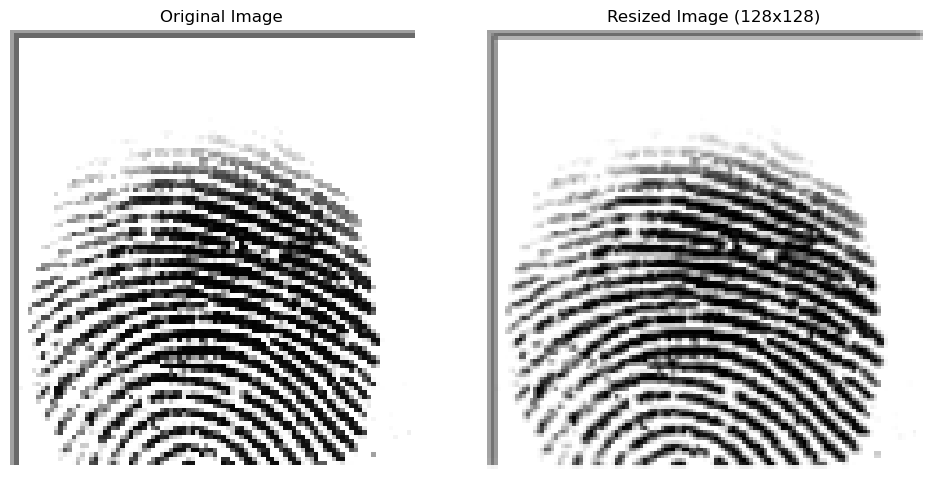

In [ ]:
bmp_files = [f for f in os.listdir(dataset_folder) if f.endswith(".BMP")]

if bmp_files:
    image_path = os.path.join(dataset_folder, random.choice(bmp_files))
else:
    print("No .BMP files found in the dataset folder.")

output_path = os.path.join(data_path, "example1_resized.BMP")
target_size = (128, 128)

try:
    with Image.open(image_path) as img:
        resized_img = img.resize(target_size)
        resized_img.save(output_path)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        axes[1].imshow(resized_img)
        axes[1].set_title(f"Resized Image ({target_size[0]}x{target_size[1]})")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error processing the image: {e}")

## Data Preprocessing

### Resize images - Uniformity

After evaluating the resizing process, we observed that the distortion introduced by resizing the images to 128x128 pixels is minimal and does not significantly affect the fingerprint patterns.

Since uniformity in image dimensions is crucial for building a consistent and reliable model, we can proceed to resize all images in the dataset to 128x128.

We save the resized images in a new folder called "resized_images"

In [5]:
resized_folder = os.path.join(data_path, "resized_images")
os.makedirs(resized_folder, exist_ok=True)

for bmp_file in bmp_files:
        input_path = os.path.join(dataset_folder, bmp_file)
        output_path = os.path.join(resized_folder, bmp_file)
        
        try:
            with Image.open(input_path) as img:
                resized_img = img.resize(target_size)
                resized_img.save(output_path)
        except Exception as e:
            print(f"Error processing {input_path}: {e}")

In [6]:
num_files = len([f for f in os.listdir(resized_folder) if os.path.isfile(os.path.join(resized_folder, f))])
print(f"{num_files} resized images")


6000 resized images


### Check size distribution

In [7]:
def check_image_uniformity(resized_folder):
    images_by_size = {}
    total_images = 0
    size_counter = Counter()

    print(f"Processing images in the folder: {resized_folder}")

    for filename in os.listdir(resized_folder):
        if filename.endswith((".png", ".BMP", ".jpg", ".jpeg")):
            filepath = os.path.join(resized_folder, filename)
            try:
                with Image.open(filepath) as img:
                    total_images += 1
                    
                    # Group by size
                    size = img.size
                    if size not in images_by_size:
                        images_by_size[size] = []
                    images_by_size[size].append((filename, np.array(img)))
                    size_counter[size] += 1
            except Exception as e:
                print(f"Error processing the image {filename}: {e}")

    print(f"\nTotal images processed: {total_images}")
    print("\nSize distribution:")
    print(f"Unique sizes found: {list(images_by_size.keys())}")
    for size, count in size_counter.items():
        print(f" - Size {size}: {count} images")

    if len(images_by_size) > 1:
        print("\nComparing two images with different sizes:")
        sizes = list(images_by_size.keys())
        size1, size2 = sizes[0], sizes[1]
        img1_info = images_by_size[size1][0]
        img2_info = images_by_size[size2][0]
        compare_images(img1_info, img2_info)
    
    return images_by_size

def compare_images(img1_info, img2_info):
    filename1, img1 = img1_info
    filename2, img2 = img2_info
    
    title1 = f"{filename1}\nSize: {img1.shape[1]}x{img1.shape[0]}"
    title2 = f"{filename2}\nSize: {img2.shape[1]}x{img2.shape[0]}"
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(img1, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(img2, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

images_by_size = check_image_uniformity(resized_folder)

Processing images in the folder: data\resized_images

Total images processed: 6000

Size distribution:
Unique sizes found: [(128, 128)]
 - Size (128, 128): 6000 images


### Balancing the dataset

Create a folder called "balanced_images" to store an equal number of male and female images.

To achieve this, 3,000 male images were randomly selected from the original dataset. For the female category, images were randomly duplicated until the total count also reached 3,000. This ensures equal representation of both categories in the dataset, making it balanced for training and analysis

In [10]:
# Script to balance the dataset

balanced_folder = os.path.join(data_path, "balanced_images")
os.makedirs(balanced_folder, exist_ok=True)

male_bal_folder = os.path.join(balanced_folder, "male")
female_bal_folder = os.path.join(balanced_folder, "female")
os.makedirs(male_bal_folder, exist_ok=True)
os.makedirs(female_bal_folder, exist_ok=True)

male_images = [img for img in os.listdir(resized_folder) if "__M_" in img and img.endswith(".BMP")]
female_images = [img for img in os.listdir(resized_folder) if "__F_" in img and img.endswith(".BMP")]

selected_male_images = random.sample(male_images, 3000)
for img in selected_male_images:
    shutil.copy(os.path.join(resized_folder, img), male_bal_folder)

for img in female_images:
    shutil.copy(os.path.join(resized_folder, img), os.path.join(female_bal_folder, img))

while len(os.listdir(female_bal_folder)) < 3000:
    img = random.choice(female_images)
    new_img_name = f"{img.split('.BMP')[0]}_copy{random.randint(1, 10000)}.BMP"
    shutil.copy(os.path.join(resized_folder, img), os.path.join(female_bal_folder, new_img_name))

print(f"Total male images in balanced folder: {len(os.listdir(male_bal_folder))}")
print(f"Total female images in balanced folder: {len(os.listdir(female_bal_folder))}")


Total male images in balanced folder: 3000
Total female images in balanced folder: 3000


### Splitting data in Train, Test and Val sets

Split the female and male sets into training, validation, and testing sets to facilitate model training and evaluation, using the following distribution:
* Training set: 72% of the images
* Validation set: 18% of the images
* Testing set: 10% of the images

In [11]:
from sklearn.model_selection import train_test_split
import shutil

In [14]:
split_folder = os.path.join(data_path, "split")

os.makedirs(split_folder, exist_ok=True)
for subset in ["train", "val", "test"]:
    for category in ["female", "male"]:
        os.makedirs(os.path.join(split_folder, subset, category), exist_ok=True)

female_images = [os.path.join(balanced_folder, "female", img) for img in os.listdir(os.path.join(balanced_folder, "female")) if img.endswith(".BMP")]
male_images = [os.path.join(balanced_folder, "male", img) for img in os.listdir(os.path.join(balanced_folder, "male")) if img.endswith(".BMP")]

train_female, test_female = train_test_split(female_images, test_size=0.1, random_state=42)
train_female, val_female = train_test_split(train_female, test_size=0.2, random_state=42)

train_male, test_male = train_test_split(male_images, test_size=0.1, random_state=42)
train_male, val_male = train_test_split(train_male, test_size=0.2, random_state=42)

for img_path in train_female + train_male:
    category = "female" if "female" in img_path else "male"
    shutil.copy(img_path, os.path.join(split_folder, "train", category))

for img_path in val_female + val_male:
    category = "female" if "female" in img_path else "male"
    shutil.copy(img_path, os.path.join(split_folder, "val", category))

for img_path in test_female + test_male:
    category = "female" if "female" in img_path else "male"
    shutil.copy(img_path, os.path.join(split_folder, "test", category))

print("Dataset successfully split into train, validation, and test sets.")

Dataset successfully split into train, validation, and test sets.


In [15]:
for subset in ["train", "val", "test"]:
    for category in ["female", "male"]:
        folder_path = os.path.join(split_folder, subset, category)
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{subset.capitalize()} - {category.capitalize()}: {num_files} files")

Train - Female: 2160 files
Train - Male: 2160 files
Val - Female: 540 files
Val - Male: 540 files
Test - Female: 300 files
Test - Male: 300 files


### Try filters

The filters are applied within the CNN itself during the training process, so we will not manually apply them for model training.

Here, I am simply plotting how different filters can enhance specific features of the fingerprint image to better understand their impact. For example, we can apply filters to highlight the edges or enhance certain patterns, giving us an idea of how a fingerprint might look with these filters applied. This visualization can provide insight into how the model might interpret features during training.

In [16]:
from PIL import Image, ImageFilter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

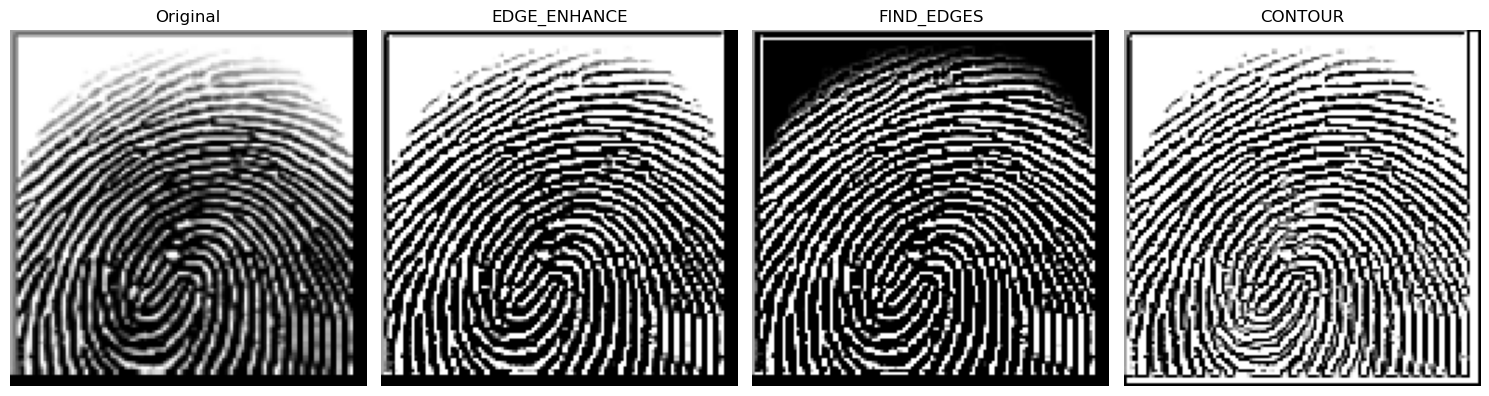

In [17]:
# Try filters on a random image (we can run the script ore times to see other images)

random_image = random.choice([img for img in os.listdir(male_bal_folder) if img.endswith(".BMP")])
image_path = os.path.join(male_bal_folder, random_image)

filters = [
    ("Original", None),
    ("EDGE_ENHANCE", ImageFilter.EDGE_ENHANCE),
    ("FIND_EDGES", ImageFilter.FIND_EDGES),
    ("CONTOUR", ImageFilter.CONTOUR),
]

try:
    with Image.open(image_path) as img:
        plt.figure(figsize=(15, 10))
        
        for i, (filter_name, filter_type) in enumerate(filters):
            if filter_type:
                filtered_img = img.filter(filter_type)
            else:
                filtered_img = img  # original
            
            plt.subplot(1, 4, i + 1)
            plt.title(filter_name)
            plt.imshow(filtered_img, cmap="gray")
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error processing the image {image_path}: {e}")

#### Load datasets and create generators

In [45]:
train_dataset_path = os.path.join(split_folder, "train")
val_dataset_path = os.path.join(split_folder, "val")
test_dataset_path = os.path.join(split_folder, "test")

# Image parameters
IMG_WIDTH, IMG_HEIGHT = 128, 128  
BATCH_SIZE = 32

### Apply Data Augmentation for train data

In [28]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest'    
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load train dataset
train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size = target_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load validation dataset
validation_generator = validation_datagen.flow_from_directory(
    val_dataset_path,
    target_size = target_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load test dataset
test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size = target_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Data generators with preprocessing are ready.")

Found 4320 images belonging to 2 classes.
Found 1080 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Data generators with preprocessing are ready.


### Get the Label Mappings

In [29]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training dataset:\n")
for key, value in labels.items():
    print(f"{key}: {value}")

Label Mappings for classes present in the training dataset:

0: female
1: male


### Plotting Sample Training Images

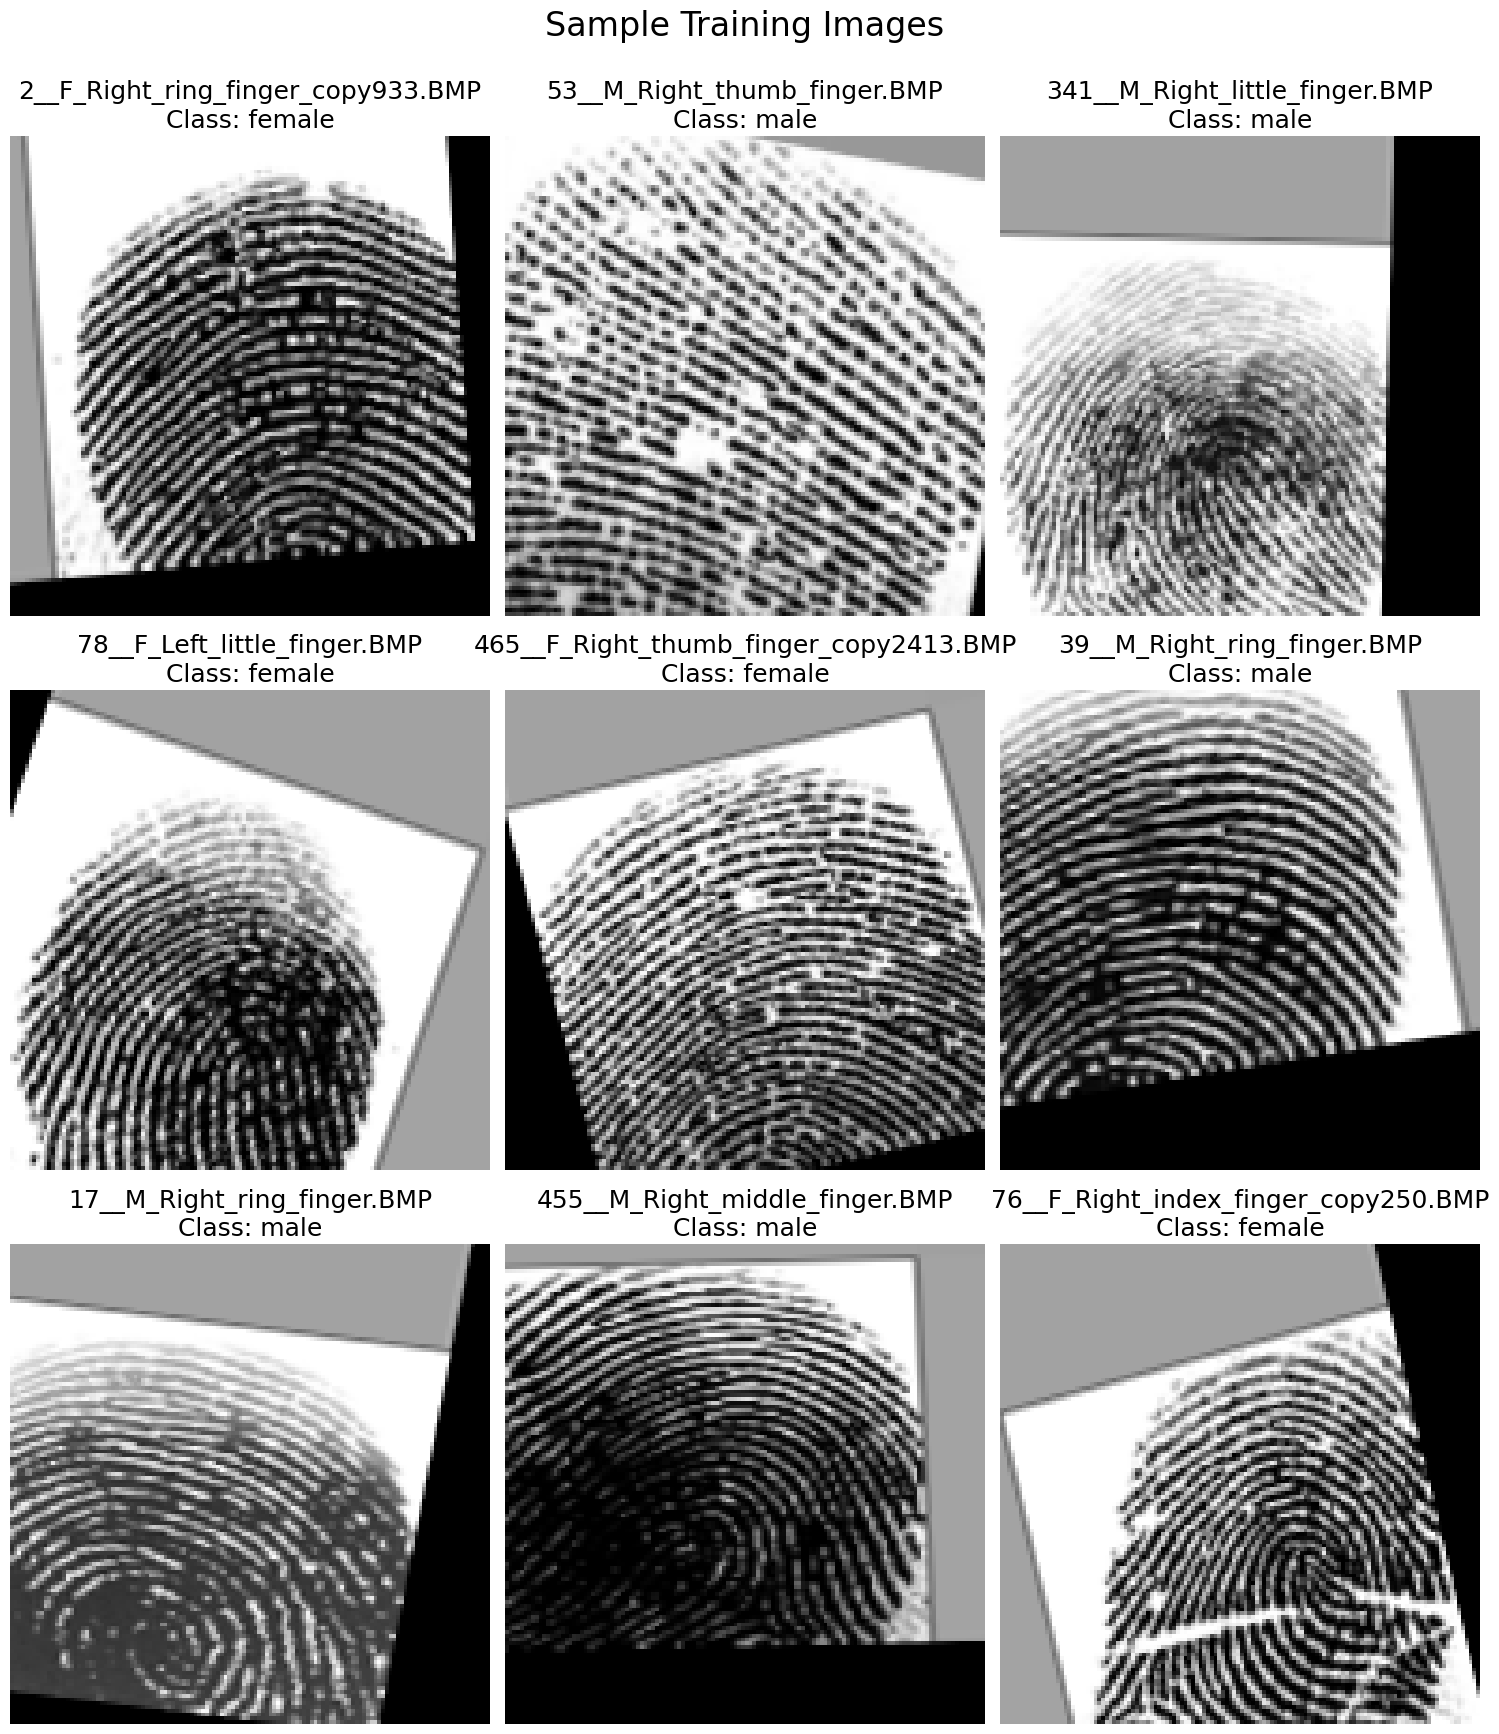

In [30]:
filenames = train_generator.filenames

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 18)) 
idx = 0 

batch_images, batch_labels = train_generator[0] 
batch_indices = train_generator.index_array[:len(batch_images)] 

for i in range(3):
    for j in range(3): 
        label = labels[np.argmax(batch_labels[idx])]
        filename = filenames[batch_indices[idx]].split("\\")[-1] 
        
        ax[i, j].set_title(f"{filename}\nClass: {label}", fontsize=18)
        ax[i, j].imshow(batch_images[idx].squeeze())
        ax[i, j].axis("off")  
        idx += 1 

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.suptitle("Sample Training Images", fontsize=24, y=0.98)
plt.show()


In [31]:
# Check the size again
images, _ = next(train_generator)

image_shapes = [img.shape for img in images]
unique_shapes = set(image_shapes)

print(f"Total images in the batch: {len(images)}")
print(f"Unique values: {unique_shapes}")


Total images in the batch: 32
Unique values: {(128, 128, 3)}


## Model Building

### Create the CNN Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

In [47]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(3, 3), padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),

        Dense(units=2, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [48]:
cnn_model = create_model()

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 activation_3 (Activation)   (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 activation_4 (Activation)   (None, 64, 64, 64)       

### Some steps before training the model:

In [34]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

### 1. Reduce Learning Rate on Plateau

ReduceLROnPlateau dynamically adjusts the learning rate when it detects that the model is no longer improving on a monitored metric

In [49]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

### 2. EarlyStopping

To stop training when the validation metrics stop improving, which avoids wasting time at unnecessary times.

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

### 3. Defining the optimizer

In [51]:
optimizer = Adam(learning_rate=0.001)

### 4. Compile the model

In [52]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training the model

In [53]:
history = cnn_model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/30
135/135 [==============================] - 195s 1s/step - loss: 0.9303 - accuracy: 0.5632 - val_loss: 0.7770 - val_accuracy: 0.5095 - lr: 0.0010
Epoch 2/30
135/135 [==============================] - 205s 2s/step - loss: 0.6972 - accuracy: 0.5850 - val_loss: 0.6548 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/30
135/135 [==============================] - 145s 1s/step - loss: 0.6781 - accuracy: 0.6009 - val_loss: 0.6560 - val_accuracy: 0.6326 - lr: 0.0010
Epoch 4/30
135/135 [==============================] - 142s 1s/step - loss: 0.6771 - accuracy: 0.6062 - val_loss: 0.6315 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/30
135/135 [==============================] - 163s 1s/step - loss: 0.6609 - accuracy: 0.6187 - val_loss: 0.6302 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 6/30
135/135 [==============================] - 166s 1s/step - loss: 0.6632 - accuracy: 0.6171 - val_loss: 0.6018 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 7/30
135/135 [==============================] - 135s 989ms

### Plotting training and validation accuracy, loss and learning rate

In [54]:
val_accuracy = history.history["val_accuracy"]
train_accuracy = history.history["accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

learning_rate = history.history.get("lr", None)

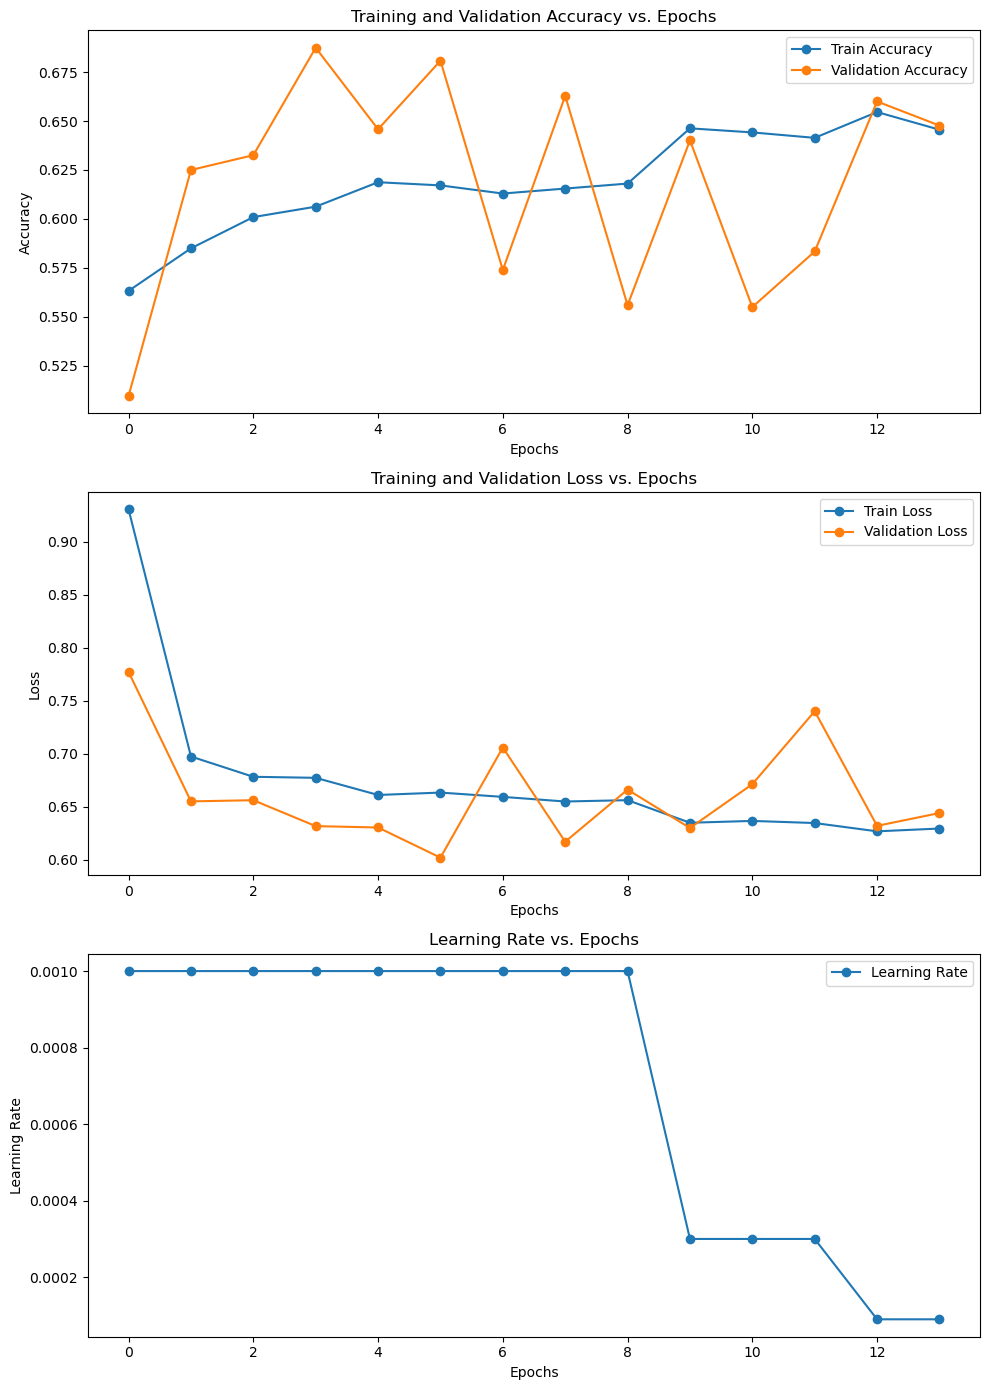

In [55]:
fig, ax = plt.subplots(nrows=3 if learning_rate else 2, ncols=1, figsize=(10, 14))

ax[0].set_title('Training and Validation Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training and Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

if learning_rate:
    ax[2].set_title('Learning Rate vs. Epochs')
    ax[2].plot(learning_rate, 'o-', label='Learning Rate')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Learning Rate')
    ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

## Model prediction on the test datset

In [56]:
predictions = cnn_model.predict(test_generator)

19/19 [==============================] - 10s 404ms/step


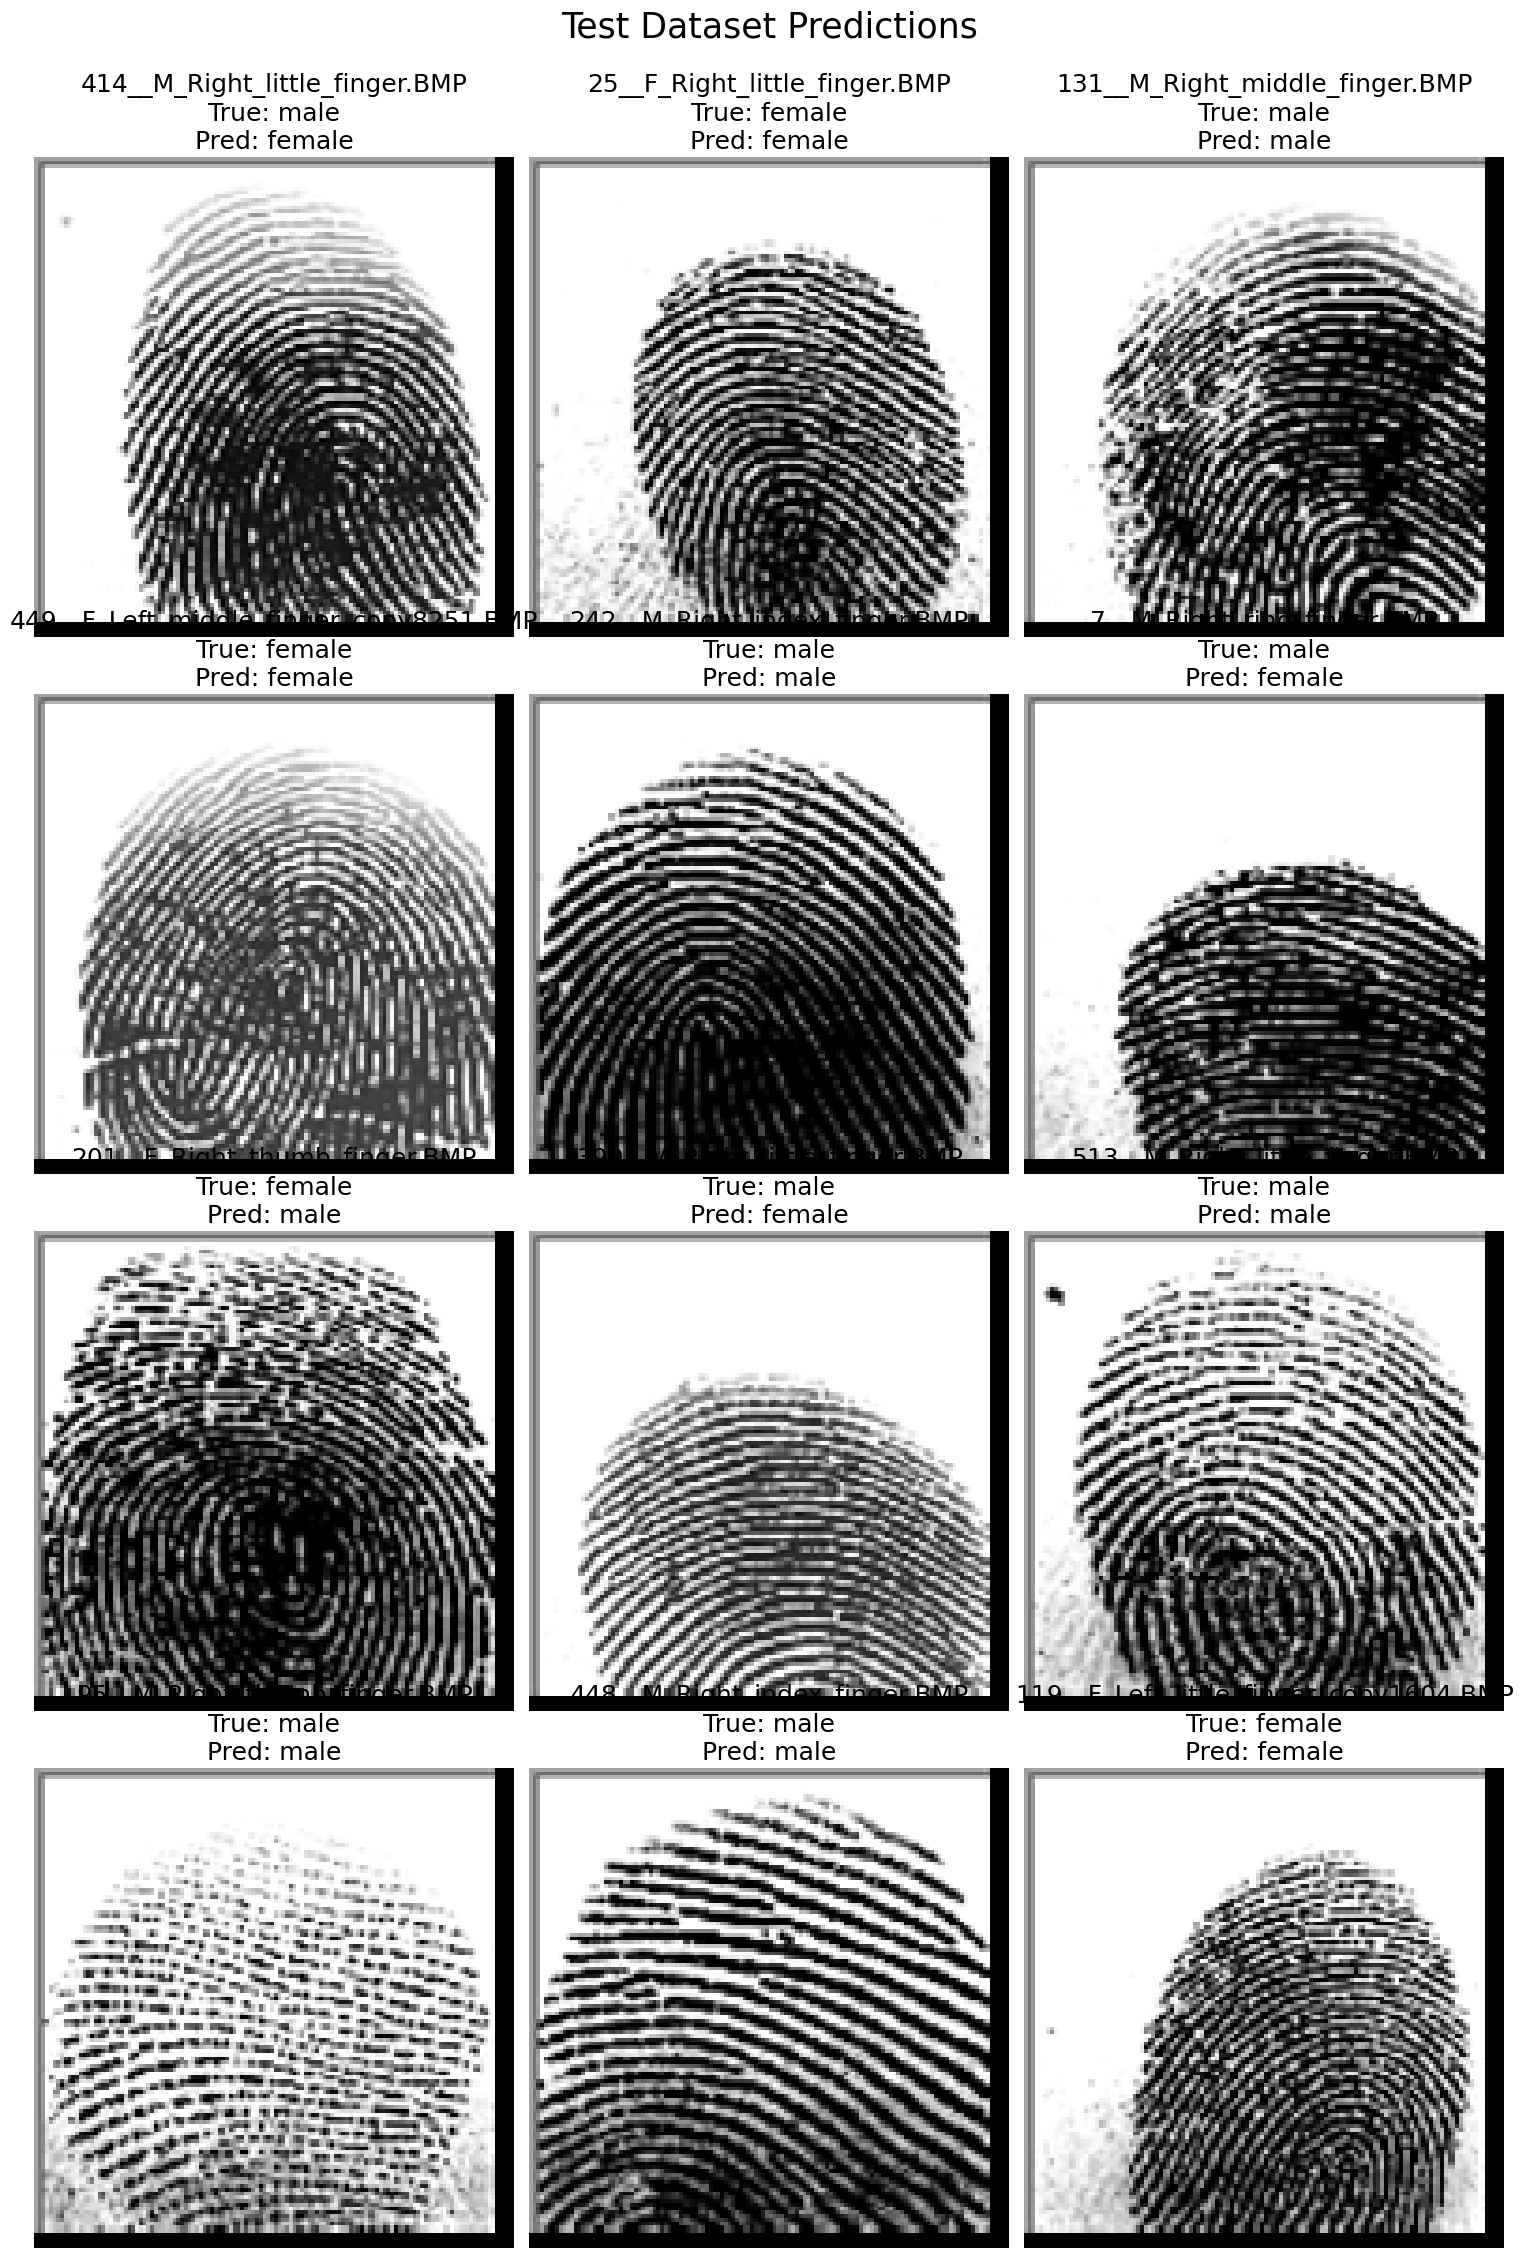

In [57]:
true_labels = test_generator.classes

class_mapping = {v: k for k, v in test_generator.class_indices.items()}

num_samples = 12  # Número de imágenes a mostrar (3x4)
random_indices = np.random.choice(len(predictions), num_samples, replace=False)

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 23))  # Cambiar a 4 filas x 3 columnas
idx = 0

for i in range(4):
    for j in range(3):
        img_idx = random_indices[idx]
        file_name = os.path.basename(test_generator.filenames[img_idx])
        true_class = class_mapping[true_labels[img_idx]]
        predicted_class = class_mapping[np.argmax(predictions[img_idx])]
        
        image = test_generator[img_idx // test_generator.batch_size][0][img_idx % test_generator.batch_size]
        ax[i, j].imshow(image.squeeze(), cmap="gray")
        ax[i, j].axis("off")
        ax[i, j].set_title(f"{file_name}\nTrue: {true_class}\nPred: {predicted_class}", fontsize=18)
        idx += 1

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.suptitle("Test Dataset Predictions", fontsize=25, y=0.98)
plt.show()

### Evaluate the model on the test dataset

In [58]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

19/19 [==============================] - 4s 191ms/step - loss: 0.6112 - accuracy: 0.6733


In [59]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.6112239956855774
Test Accuracy: 0.6733333468437195


## Plotting the Classification Metrics

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [61]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

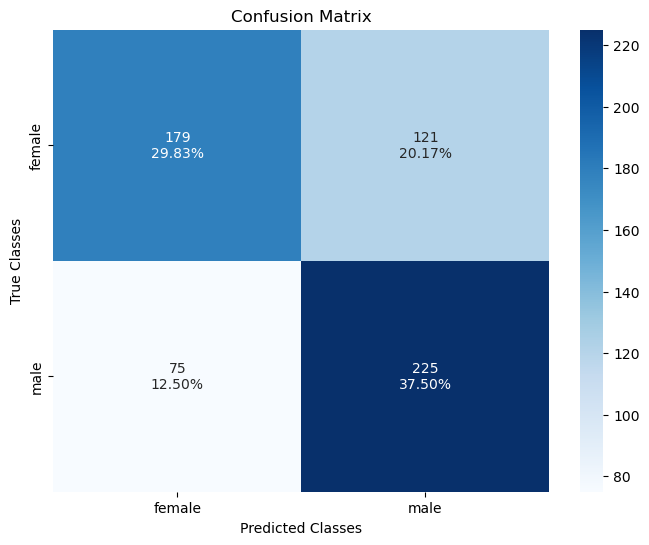

In [62]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = [f"{value:0}" for value in cf_mtx.flatten()]
group_percentages = [f"{value:.2%}" for value in cf_mtx.flatten() / np.sum(cf_mtx)]
box_labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize=(8, 6))
sns.heatmap(cf_mtx, annot=box_labels, fmt="", cmap="Blues", xticklabels=["female", "male"], yticklabels=["female", "male"])
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()


In [63]:
class_names = [class_mapping[i] for i in range(len(class_mapping))]
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      female       0.70      0.60      0.65       300
        male       0.65      0.75      0.70       300

    accuracy                           0.67       600
   macro avg       0.68      0.67      0.67       600
weighted avg       0.68      0.67      0.67       600

